# In Class & Final Assignment
## AI Technology Market Analysis Assignment
### Group Project Using NLP and Network Analysis

---

## Overview
Conduct a comprehensive analysis of AI technology markets by combining Natural Language Processing (NLP) and Network Analysis techniques. Use either the provided dataset or identify suitable alternative data sources that enable meaningful insights into AI market dynamics.

---

## Core Requirements

### Data Processing with LLMs - OK
Implement local or cloud-based Large Language Models (LLMs) to:
- Extract and structure relevant market data
- Identify network relationships between entities
- Perform named entity recognition and extraction
- Transform unstructured text into analyzable formats

### Network Analysis
Design and construct meaningful networks from the extracted data:
- Implement bi-partite network analysis and corresponding projections
- Calculate and interpret key network metrics:
  - Various centrality measures - OK
  - Network structure indicators - OK, men "Graph is disconnected"
  - Community detection (if applicable) - maybe
- Provide clear interpretation of network analysis results

### Text Classification
Select and implement one of these approaches:
- LLM-based classification system
- Few-shot learning implementation using SetFit
- Traditional NLP classification methods (using existing or synthetic training data)

---

## Optional Extensions

### Topic Modeling
Leverage LLMs to extract and categorize key themes and topics:
- Apply BERTopic for advanced topic modeling
- Create clear and insightful visualizations of:
  - Topic distributions
  - Theme relationships
  - Temporal patterns (if applicable)

---

## Deliverables

### Analysis Notebooks
Well-documented Jupyter notebooks containing:
- Complete analysis pipeline
- Clear code documentation
- Inline result interpretation
- Reproducible implementation

### Executive Summary
Concise PDF slide deck (max 6 slides) including:
- Problem statement and approach
- Key findings and insights
- Visual representation of critical results


## Data Processing with LLMs 


### Install & Import Libraries

In [18]:
# Install required packages from requirements.txt
!pip install -r requirements.txt -q

# importing the clear_output function from IPython.display module to reduce noise in outputs...
from IPython.display import clear_output

# Datascrapping libs
import os
import requests
from bs4 import BeautifulSoup
import time

# Datahandling
import os
import re

# LLM Libs & Setup
from openai import OpenAI
import json
from pydantic import BaseModel, Field
from typing import List, Optional
import textwrap

# Wikipedia import
import wikipediaapi

# Network analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import holoviews as hv
import hvplot.networkx as hvnx
from community import community_louvain
from holoviews import opts
import plotly.graph_objects as go
import random
from community import community_louvain

# Model prediction
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sklearn.metrics import classification_report

# Gradio deployment
import gradio as gr


python(74455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning:

This process (pid=73722) is multi-threaded, use of forkpty() may lead to deadlocks in the child.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### API SETUP (User Together API-Key Input required)...
For the LLM-processing you will need to input a Together API Key in the field "INSERT TOKEN" below
 * (https://api.together.ai/signin)

In [ ]:
# Setup OpenAI client with custom TogetherAPI key and base URL
TOGETHER_API_KEY = "INSERT TOKEN" # INSERT YOUR TOKEN

client = OpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=TOGETHER_API_KEY
)

### Setup + Data Extraction

#### Fetching Breaking Bad Data from Fandom (using subtitles of each season/episode)

In [13]:
# Base URL
base_url = "https://breakingbad.fandom.com/wiki/Category:Breaking_Bad_Subtitles"

def get_season_links(base_url, target_seasons):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    season_links = []

    for link in soup.select('a.category-page__member-link'):
        for season in target_seasons:
            if f"Season_{season}" in link['href']:
                season_links.append("https://breakingbad.fandom.com" + link['href'])
    return season_links

def get_episode_links(season_url):
    response = requests.get(season_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    episode_links = []
    for link in soup.select('a.category-page__member-link'):
        episode_links.append("https://breakingbad.fandom.com" + link['href'])
    return episode_links

def get_subtitles(episode_url):
    response = requests.get(episode_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    subtitle_pre = soup.find("pre")
    if subtitle_pre:
        subtitles = subtitle_pre.get_text(strip=True)
        return subtitles
    return ""

def save_subtitles(episode_name, subtitles, season):
    # Handle "5A" and "5B" cases
    season_folder = f"Season_{season}"
    os.makedirs(f"subtitles/{season_folder}", exist_ok=True)
    file_path = f"subtitles/{season_folder}/{season_folder} - {episode_name}.txt"
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(subtitles)

def scrape_and_save_subtitles():
    target_seasons = [1, 2, 3, 4, "5A", "5B"] # ALL SEASONS
    # REPLACE # IF ONLY SEASON 1 IS WANTED: target_seasons = [1] # ONLY SEASON 1?
    season_links = get_season_links(base_url, target_seasons)

    for season_url in season_links:
        # Extract season from URL
        season = None
        for s in target_seasons:
            if f"Season_{s}" in season_url:
                season = s
                break

        if season:
            episode_links = get_episode_links(season_url)
            for episode_url in episode_links:
                subtitles = get_subtitles(episode_url)
                episode_name = episode_url.split("/")[-1].replace("_", " ")
                save_subtitles(episode_name, subtitles, season)
                print(f"Saved subtitles for {episode_name} in Season {season}")
# Run the scraper and saver
scrape_and_save_subtitles()

clear_output()
print("Manuscript Saved!")

Manuscript Saved!


#### Data Cleaning

In [14]:
def clean_subtitle(input_text):
    # Fjern linjer med tidsstempler og numre
    lines = input_text.split('\n')
    cleaned_lines = []
    skip_next = False

    for line in lines:
        if skip_next:
            skip_next = False
            continue
        if re.match(r'^\d+$', line.strip()) or '-->' in line:
            skip_next = True
            continue
        if line.strip():
            cleaned_lines.append(line.strip())

    return ' '.join(cleaned_lines)

def process_directory(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.txt'):
                file_path = os.path.join(dirpath, filename)

                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()

                cleaned_content = clean_subtitle(content)

                with open(file_path, 'w', encoding='utf-8') as file:
                    file.write(cleaned_content)
# path to the folder containing our fetched subtitles
root_directory = 'subtitles/'

process_directory(root_directory)

### Definition of Extraction Schema

In [15]:
# we initialize the wikipedia api
wiki_wiki = wikipediaapi.Wikipedia(
    language='en',  # we set the language to english
    user_agent='BreakingBadNetwork/1.0'  # we insert a user-agent string for wiki
)

# we fetch a specific article
page = wiki_wiki.page('List of characters in the Breaking Bad franchise')

# we check if the article exists and print the entire content
if page.exists():
    article_content = page.text # saves the article as variable
    print("Title: ", page.title)
    print("Content: ", page.text[:100])  # we retrieve the entire text of the article
else:
    print("the article does not exist")

# save as a file
with open("wiki_breaking_bad_characters.txt", "w", encoding="utf-8") as file:
    file.write(page.text)

Title:  List of characters in the Breaking Bad franchise
Content:  Breaking Bad is a crime drama franchise created by American filmmaker Vince Gilligan. It started wit


### Context / Prompt creation

 * We will need some context for the LLM when the manuscript is going to be processed. 
 * For that - we will use the Wikipedia article "List of characters in the Breaking Bad franchise" 
     * (https://en.wikipedia.org/wiki/List_of_characters_in_the_Breaking_Bad_franchise)
 * The purpose of it is to ensure that the LLM understands which characters is present during the processing of the manuscript
 * The result: Improvement of the network creation

#### Create LLM summary of characters to be used as part of the prompt during processing of the manuscript (subtitles)

In [18]:
SUM_PROMPT = """
You are an expert analyst of fictional characters. Your task is to summarize key information about characters from the Breaking Bad universe. For each character provided, you should:

1. State their name
2. Describe their primary role in the story
3. Outline their key relationships to other characters

Your summary should be concise yet informative, focusing only on the most important aspects of each character. Avoid including any information not explicitly provided in the input. If you're unsure about any details, do not speculate.

Format your response as a bullet-point list, with each character as a main point and their details as sub-points. You need to focus on that you state the different variances of the characters names in the summary.

Example format:
• Character Name:
  - Role: [Brief description of their role]
  - Key Relationships: [List of important relationships]

Provide this summary based solely on the information given in the input, without adding any external knowledge about Star Wars.
"""

response = client.chat.completions.create(
    model='meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 
    messages=[
        {'role': 'system', 'content': SUM_PROMPT},
        {'role': 'user', 'content': f"Summarize these Breaking Bad characters:\n\n{article_content}"}
    ],
    temperature=0.7
)

article_sum = response.choices[0].message.content

In [21]:
article_sum[:1000]

"• Walter White (also known by his alias Heisenberg):\n  - Role: A high school chemistry teacher turned methamphetamine manufacturer and dealer.\n  - Key Relationships: Skyler White (wife), Walter Jr. (son), Jesse Pinkman (business partner), Hank Schrader (brother-in-law), Saul Goodman (lawyer), Mike Ehrmantraut (associate).\n\n• Skyler White:\n  - Role: Walter's wife, who becomes involved in his money laundering activities.\n  - Key Relationships: Walter White (husband), Walter Jr. (son), Hank Schrader (brother-in-law), Marie Schrader (sister), Saul Goodman (lawyer).\n\n• Jesse Pinkman:\n  - Role: A small-time methamphetamine user, manufacturer, and dealer who becomes Walter's business partner.\n  - Key Relationships: Walter White (business partner), Andrea Cantillo (girlfriend), Brock Cantillo (Andrea's son), Saul Goodman (lawyer), Mike Ehrmantraut (associate).\n\n• Hank Schrader:\n  - Role: A U.S. Drug Enforcement Administration (DEA) agent and Walter's brother-in-law.\n  - Key Rela

#### Manuscript (subtitles) --> LLM Processing --> JSON schema of characters, events, locations & seasons

In [ ]:
# Here we use the create the system prompt for the LLM - It contains infomation of what we want the LLM to look for
# Furthermore, we specify "Background Information" to be the earlier LLM-processed summary of the Wikipedia article as context for the TV-show
SYSTEM_PROMPT = f"""
You are an assistant specialized in analyzing and structuring information about TV series. Your task is to help build a network of relationships between various entities in a given TV series, based on the following summary:

Background Information:
{article_sum}

This series features a range of characters involved in complex relationships. Your primary goal is to analyze these connections and structure them into JSON format.

Your task includes:
1. Identifying relevant entities such as characters, locations, events, and seasons in the series.
2. Establishing meaningful relationships between these entities, noting when each relationship occurs (season).

Key Guidelines:
- Each entity should have a unique name and a defined type (e.g., 'character', 'location').
- Relationships must always specify the source entity, target entity, relationship type, and season.
- Use only predefined relationship types provided.

Additionally, you should:
- Be able to answer questions about the structure and relationships in the series.
- Offer suggestions for expanding or refining the network.
- Identify central characters, significant events, and key locations, using network connections as a basis for insight into the series' narrative structure and character development.

Explain your choices and reasoning as needed, ensuring that your analysis aids in understanding the series’ narrative structure over time.

Output JSON only.
"""

In [ ]:
import json
import os
from typing import Dict, Any

# path to the subtitles directory
subtitles_dir = 'subtitles'

def extract_relationships(script_content: str, episode_name: str, season_number: int) -> Dict[str, Any]:
    prompt = f"""
    Analyze the following Breaking Bad episode script and identify entities and their relationships.
    Episode: {episode_name}
    Season: {season_number}

    Please output ONLY a valid JSON object following exactly this schema:
    {{
        "entities": [
            {{
                "name": "string",
                "type": "Character" | "Location" | "Event" | "Season"
            }}
        ],
        "relationships": [
            {{
                "source": "string",
                "relation": "friend of" | "enemy of" | "related to" | "married to" | "works with" | "lives in" | "visits" | "owns" | "participates in" | "witnesses" | "causes" | "appears in" | "is central to" | "introduces" | "concludes" | "develops" | "part of",
                "target": "string",
                "season": {season_number}
            }}
        ]
    }}

    Script content:
    {script_content[:1000]}...
    """

    try:
        response = client.chat.completions.create(
            model='Qwen/Qwen2.5-72B-Instruct-Turbo',
            messages=[
                {'role': 'system', 'content': SYSTEM_PROMPT},
                {'role': 'user', 'content': prompt}
            ],
            temperature=0.7
        )

        response_text = response.choices[0].message.content.strip()

        # get response and fix weird characters
        response_text = ''.join(char for char in response.choices[0].message.content if ord(char) >= 32 or char in '\n\r\t')


        # Ensure we get valid JSON
        try:
            data = json.loads(response_text)
            return data
        except json.JSONDecodeError:
            # Fallback: Try to extract JSON from response
            json_start = response_text.find('{')
            json_end = response_text.rfind('}') + 1
            if json_start >= 0 and json_end > json_start:
                json_str = response_text[json_start:json_end]
                return json.loads(json_str)
            raise

    except Exception as e:
        print(f"Error processing episode {episode_name}: {str(e)}")
        return {"entities": [], "relationships": []}

def analyze_all_episodes(subtitles_dir: str) -> Dict[str, Any]:
    all_episode_data = {}

    for season_dir in sorted(os.listdir(subtitles_dir)):
        season_path = os.path.join(subtitles_dir, season_dir)
        if os.path.isdir(season_path):
            season_number = int(season_dir.split('_')[1]) if season_dir.split('_')[1].isdigit() else 0

            for episode_file in sorted(os.listdir(season_path)):
                if episode_file.endswith('.txt'):
                    episode_path = os.path.join(season_path, episode_file)
                    clean_episode_name = episode_file.replace('%27', "'").replace('%20', " ")

                    try:
                        with open(episode_path, 'r', encoding='utf-8') as file:
                            script_content = file.read()

                        episode_data = extract_relationships(script_content, clean_episode_name, season_number)
                        if episode_data["entities"] or episode_data["relationships"]:
                            all_episode_data[f"{season_dir} - {clean_episode_name}"] = episode_data

                    except Exception as e:
                        print(f"Error reading file {episode_path}: {str(e)}")
                        continue

    return all_episode_data

# Analyze episodes and save results as JSON
all_episode_data = analyze_all_episodes(subtitles_dir)

# Save to JSON file
with open('breaking_bad_analysisV2.json', 'w', encoding='utf-8') as f:
    json.dump(all_episode_data, f, indent=4, ensure_ascii=False)

# Optional: Print summary of results
print("\nAnalysis complete! Results saved to 'breaking_bad_analysisV2.json'")
print(f"Processed {len(all_episode_data)} episodes")

# Optional: Print sample of the data in JSON format
print("\nSample of the data:")
print(json.dumps(dict(list(all_episode_data.items())[:1]), indent=4))

Error processing episode Season_5B - Buried subtitles.txt: Invalid control character at: line 36 column 33 (char 763)

Analysis complete! Results saved to 'breaking_bad_analysis.json'
Processed 61 episodes

Sample of the data:
{
    "Season_1 - Season_1 - ...and the Bag's in the River subtitles.txt": {
        "entities": [
            {
                "name": "Walter White",
                "type": "Character"
            },
            {
                "name": "Classroom",
                "type": "Location"
            },
            {
                "name": "Chemistry Lesson",
                "type": "Event"
            },
            {
                "name": "Season 1",
                "type": "Season"
            }
        ],
        "relationships": [
            {
                "source": "Walter White",
                "relation": "teaches",
                "target": "Chemistry Lesson",
                "season": 1
            },
            {
                "source": "Wal

## Network Analysis 

In [10]:
import json

# Load the JSON data
with open('breaking_bad_analysisV2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract entities and relationships from each episode
entities = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        entities.add((entity["name"], entity["type"]))

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

print(f"Loaded {len(entities)} entities and {len(relationships)} relationships.")


Loaded 275 entities and 594 relationships.


In [11]:
import networkx as nx

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes with their type as an attribute
for name, entity_type in entities:
    G.add_node(name, entity_type=entity_type)

# Add edges with relationship and season as attributes
for source, relation, target, season in relationships:
    G.add_edge(source, target, relation=relation, season=season)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 286 nodes and 493 edges.


In [13]:
import json
import networkx as nx
import plotly.graph_objects as go

# Load the JSON data
with open('breaking_bad_analysisV2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Initialize graph
G = nx.Graph()
characters = set()
relationships = []

for episode_data in data.values():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

    for relationship in episode_data["relationships"]:
        relationships.append((relationship["source"], relationship["relation"], relationship["target"], relationship["season"]))

# Add nodes and edges to the graph
for char in characters:
    G.add_node(char, type="Character")

for source, relation, target, season in relationships:
    if source in G and target in G:
        G.add_edge(source, target, relation=relation, season=season)

# Calculate various centrality measures for node significance
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Create a composite importance score
node_importance = {
    node: (degree_centrality[node] + betweenness_centrality[node] + eigenvector_centrality[node]) / 3
    for node in G.nodes
}

# Scale node sizes based on importance
node_size = [20 + 100 * node_importance[node] for node in G.nodes]

# Use a more spread out layout with stronger repulsion
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Extract edge positions
edge_x, edge_y = [], []
edge_texts = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_texts.append(f"{edge[0]} - {edge[2]['relation']} - {edge[1]}<br>Season: {edge[2]['season']}")

# Extract node positions
node_x, node_y, node_text = [], [], []
for node in G.nodes:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(
        f"Character: {node}<br>"
        f"Degree Centrality: {degree_centrality[node]:.3f}<br>"
        f"Betweenness Centrality: {betweenness_centrality[node]:.3f}<br>"
        f"Eigenvector Centrality: {eigenvector_centrality[node]:.3f}"
    )

# Create Plotly figure
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.8, color='rgba(169,169,169,0.5)'),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes],
    textposition="top center",
    hovertext=node_text,
    hoverinfo='text',
    marker=dict(
        size=node_size,
        color=[node_importance[node] for node in G.nodes],
        colorscale='Viridis',
        line=dict(width=1, color='white'),
        showscale=True,
        colorbar=dict(title="Character Importance")
    )
))

# Customize layout
fig.update_layout(
    title={
        'text': "Breaking Bad Character Network",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    width=1200,
    height=1000,
    showlegend=False,
    hovermode='closest',
    plot_bgcolor='rgb(250,250,250)',
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

# Add zoom capabilities and better interaction
fig.update_layout(
    dragmode='pan',
    clickmode='event+select'
)

fig.show()

In [19]:
# Load data and create graph
with open('breaking_bad_analysisV2.json', 'r') as file:
    data = json.load(file)

G = nx.Graph()
relation_types = set()

for episode_data in data.values():
    for rel in episode_data.get('relationships', []):
        G.add_edge(rel['source'], rel['target'], relation=rel['relation'])
        relation_types.add(rel['relation'])

# Apply community detection for clustering
partition = community_louvain.best_partition(G)
unique_communities = set(partition.values())
community_colors = {community: f'#{random.randint(0, 0xFFFFFF):06x}' for community in unique_communities}

# Separate nodes by community for modular layout
# Create a dictionary to hold positions of each node by community
community_positions = {}
for community in unique_communities:
    # Subgraph for each community
    subgraph = G.subgraph([node for node in G.nodes() if partition[node] == community])
    # Apply spring layout to each community separately
    pos = nx.spring_layout(subgraph, k=0.4, iterations=50)
    community_positions.update(pos)

# Spread communities apart to avoid overlap
offset = 3.0  # Adjust to control spacing between communities
for i, community in enumerate(unique_communities):
    for node in [n for n in G.nodes() if partition[n] == community]:
        community_positions[node][0] += (i % 5) * offset
        community_positions[node][1] += (i // 5) * offset

# Create color map for relation types
relation_colors = {rel: f'#{random.randint(0, 0xFFFFFF):06x}' for rel in relation_types}

# Create edge traces with color based on relation type
edge_traces = [
    go.Scatter(
        x=[community_positions[e[0]][0], community_positions[e[1]][0], None],
        y=[community_positions[e[0]][1], community_positions[e[1]][1], None],
        line=dict(width=0.5, color=relation_colors[e[2]['relation']]),
        hoverinfo='text',
        text=e[2]['relation'],
        mode='lines'
    ) for e in G.edges(data=True)
]

# Calculate node sizes based on degree
node_sizes = [10 + 5 * G.degree(node) for node in G.nodes()]

# Create node trace with community-based coloring
node_trace = go.Scatter(
    x=[community_positions[node][0] for node in G.nodes()],
    y=[community_positions[node][1] for node in G.nodes()],
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        size=node_sizes,
        color=[community_colors[partition[node]] for node in G.nodes()],
        line=dict(width=2)
    ),
    textfont=dict(size=8)
)

# Create figure
fig = go.Figure(data=edge_traces + [node_trace])
fig.update_layout(
    title="Breaking Bad Network with Clustered Community Colors",
    showlegend=False,
    width=1200,
    height=1000,
    hovermode='closest',
    margin=dict(b=20, l=5, r=5, t=40),
    annotations=[dict(
        text="Breaking Bad Network with Clustered Community Colors",
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002
    )],
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()


/tmp/ipykernel_9877/3580765938.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


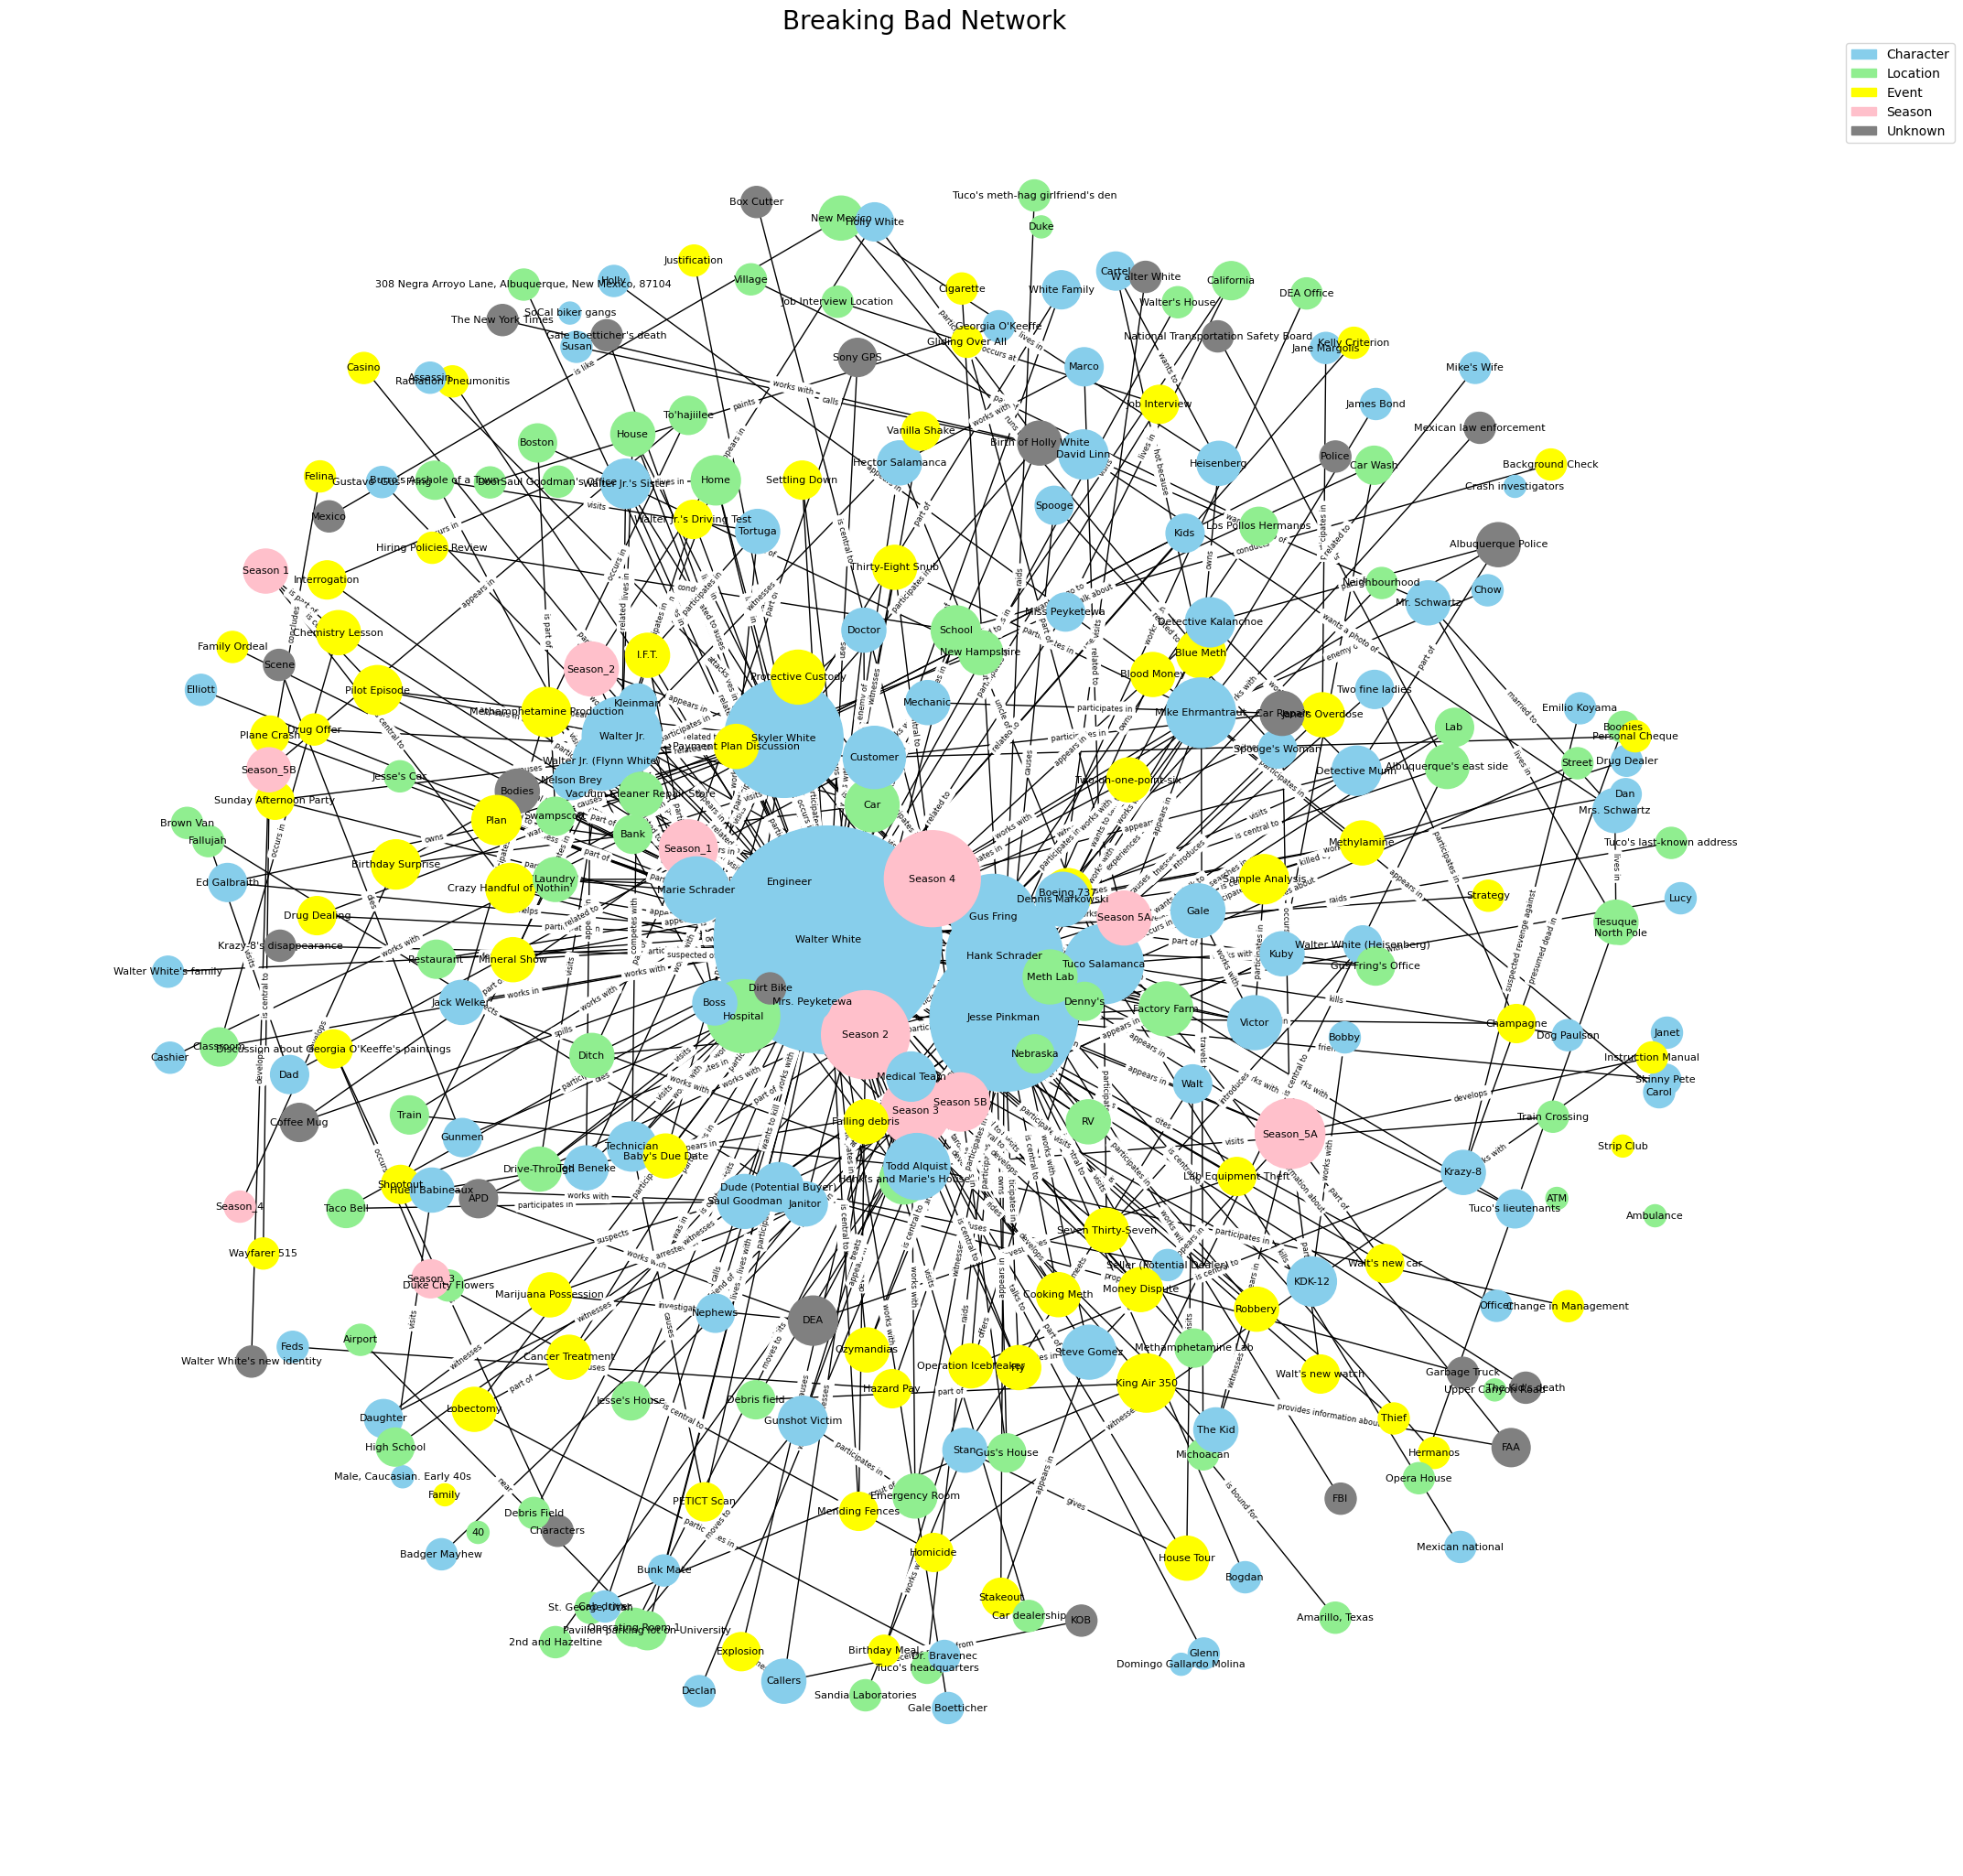

Network visualization has been saved as 'breaking_bad_network.png'


In [36]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Læs JSON-filen
with open('breaking_bad_analysisV2.json', 'r') as file:
    data = json.load(file)

# Opret en graf
G = nx.Graph()

# Tilføj noder og kanter
for episode, content in data.items():
    for entity in content['entities']:
        G.add_node(entity['name'], type=entity['type'])
    
    for relation in content['relationships']:
        source = relation['source']
        target = relation['target']
        if source not in G.nodes():
            G.add_node(source, type='Unknown')
        if target not in G.nodes():
            G.add_node(target, type='Unknown')
        G.add_edge(source, target, 
                   relation=relation['relation'], 
                   season=relation['season'])

# Definer farver for forskellige nodetyper
color_map = {'Character': 'skyblue', 'Location': 'lightgreen', 
             'Event': 'yellow', 'Season': 'pink', 'Unknown': 'gray'}

# Få node farver og størrelser
node_colors = [color_map.get(G.nodes[node].get('type', 'Unknown'), 'gray') for node in G.nodes()]
node_sizes = [300 * (1 + G.degree(node)) for node in G.nodes()]

# Tegn grafen
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=node_sizes, font_size=8)

# Tilføj kant labels
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Tilføj legende
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=color, label=type) for type, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

plt.title("Breaking Bad Network", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("breaking_bad_network.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

print("Network visualization has been saved as 'breaking_bad_network.png'")

## Text Classification

In [1]:
# read JSON data and extract only characters
with open("breaking_bad_analysisV2.json", "r") as file:
    data = json.load(file)

# find all unique characters from "entities"
characters = set()
for episode, episode_data in data.items():
    for entity in episode_data["entities"]:
        if entity["type"] == "Character":
            characters.add(entity["name"])

# convert to a sorted list for consistent display
characters = sorted(characters)

# function to compare the relationship between two selected characters
def compare_relationships(model, char1, char2):
    result = f"Comparing relationship between {char1} and {char2}:\n"
    
    # test relationship both ways
    forward = model.predict([f"{char1} - {char2}"])[0]
    backward = model.predict([f"{char2} - {char1}"])[0]
    
    # add the result for each pair
    result += f"\n{char1} <-> {char2}:\n"
    result += f"  {char1} -> {char2}: {forward}\n"
    result += f"  {char2} -> {char1}: {backward}\n"
    
    return result

# gradio interface function
def gradio_interface(char1, char2):
    return compare_relationships(model, char1, char2)

# create dropdown menus with character options
char1_dropdown = gr.Dropdown(choices=characters, label="Select first character (char1)")
char2_dropdown = gr.Dropdown(choices=characters, label="Select second character (char2)")
output = gr.Textbox(label="Results")

# initialize and start the gradio app
gr.Interface(fn=gradio_interface, inputs=[char1_dropdown, char2_dropdown], outputs=output, title="Relationship Comparison").launch()


NameError: name 'json' is not defined